# <center> Pandemic Watching

In [62]:
#importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from pprint import pprint
import numpy as np
import scipy.stats as st
from config import m_api_key
from config import t_api_key

In [63]:
# Creating Dataframe of Netflix Movies  ( based out of www.flixable.com)
df = pd.read_csv('flixable_df.csv')
df.head()

,Unnamed: 0,date,link,title,description,href,rating
0,0,January 29,https://flixable.com/title/below-zero/,Below Zero,2021,https://www.imdb.com/title/tt4016994/?ref_=tt_...,7.5/10
1,1,January 29,https://flixable.com/title/finding-ohana/,Finding ‘Ohana,2021,https://www.imdb.com/title/tt10332588/?ref_=tt...,6.1/10
2,2,January 29,https://flixable.com/title/the-dig/,The Dig,2021,https://www.imdb.com/title/tt3661210/?ref_=tt_...,7.2/10
3,3,January 29,https://flixable.com/title/we-are-the-brooklyn...,We Are: The Brooklyn...,2021,https://www.imdb.com/title/tt3661210/?ref_=tt_...,7.2/10
4,4,January 28,https://flixable.com/title/june-kopi/,June & Kopi,2021,https://www.imdb.com/title/tt13728764/?ref_=tt...,6.8/10


In [64]:
#extracting list of movies released in 2019 and 2020 
movie19 = df.loc[df['description']==2019,'title']
movie20 = df.loc[df['description']==2020,'title']
print(f'Total number of movies in 2019 are {len(movie19)}')
print(f'Total number of movies in 2020 are {len(movie20)}')

Total number of movies in 2019 are 972
Total number of movies in 2020 are 877


### Creating functions 

In [65]:
def movie_id(movie_list):#-------------- need to optimise the query-----------------------
    tmdb_df = pd.read_json('movie_ids_02_01_2021.json',lines = True)
#     tmdb_df = pd.read_json('movie_ids_02_01_2021.json',lines = True)
    
    tmdb_df.rename(columns = {'original_title': 'title'},inplace = True)
    tmdb_df.set_index('title')
    id_df = pd.merge(tmdb_df, movie19, how='inner', on = 'title')
    imdb_id = []
    name = []
    revenue = []
    c= 0
    for ids in id_df['id']:
        try:
            
            target_url = f'https://api.themoviedb.org/3/movie/{ids}?api_key={t_api_key}'
            response = requests.get(target_url)
            data = response.json()
    #         pprint(data)
            imdb_id.append(data['imdb_id'])
            name.append(data['title'])
            revenue.append(data['revenue'])
            print(f'Revenue found for tmdb id {ids}')
            c+=1
        except:
            print(f'No revenue data found for tmdb id {ids} ')

    revenue_df  = pd.DataFrame({'Title': name, 'MovieID': imdb_id, 'revenue':revenue})
    print(f'----------------------------------------------------------------------------\n Revenue Data extracted successfully for {c} movies\n----------------------------------------------------------------------------')
    return (revenue_df)
            


def fetch_db (movies):
    title = []
    genre = []
    lang = []
    idx = []
    irating = []
    ivotes = []
    year = []
    count = 0
    print('--------------------------------------\nExtracting Data from OMDB\n--------------------------------------')
    for each_movie in movies:
        url = f"http://www.omdbapi.com/?t={each_movie}&apikey={m_api_key}" 
#         print(url)
        try:

            response = requests.get(url)
            data = response.json()
            title.append(data['Title'])
            ivotes.append(data['imdbVotes'])
            irating.append(data['imdbRating'])
            idx.append(data['imdbID'])
            genre.append(data['Genre'].split(','))
            print(f'Movie: {each_movie} check')
        except:
            print(f'Movie: {each_movie}  details not found')
            count+=1
   
    movie_df = pd.DataFrame({'MovieID':idx, 'Title': title, 'Votes':ivotes, 'Rating': irating, 'Genre': genre})
    print(f'--------------------------------------\nTotal Movies in the Database  :  {len(movie_df)}      \n--------------------------------------\nTotal Missing Movies  :  {count}      \n--------------------------------------')

    return(movie_df)


def outlier(df,col):
    q1 = np.quantile(df[col],0.25) 
    q3 = np.quantile(df[col],0.75)
    IQR = q3 - q1
    upbound = q3+(1.5* IQR)
    lowbound = q1-(1.5*IQR)
    fig1, ax1 = plt.subplots()
    ax1.boxplot(df[col],  sym = 'r', showmeans = True)
    plt.show()   

    #dropping the outliers
    for idx, srs in df.iterrows():
        if srs[col]<lowbound:
            df = df.drop(index = idx)
        if srs[col]>upbound:
            df = df.drop(index = idx)
    plt.show() 
    print(f'---------------------- After dropping Outliers----------------------')
    print(f'-----------------------Final Data Points = {len(df)}----------------------')
    df.hist()
    plt.show() 
    

def regress(x,y,nx,ny):
    slope, inter, r, p, std = st.linregress(x,y)
    x_axis_19 = np.arange(max(x))
    y_pred_19 = slope*x_axis_19 +inter
    plt.plot(x_axis_19,y_pred_19, c='r')
    print(f'r is {r} and p is {p}')
    plt.annotate(f'y = {round(slope,4)}x + {round(inter,2)} ', (nx,ny), c= 'r',fontsize = 10)
    plt.show()
    
def rating_votes(df, gen):
    v_count=0
    r_count=0
    rev_count = 0
    new_r_gen = []
    new_r_gen = gen
    for genre in gen['Genre']:
        for idx , srs in df.iterrows():
            for g in srs['Genre']:
                if g == genre:
                    v_count+=srs['Votes']/100000
                    r_count+=srs['Rating']
        new_r_gen.loc[new_r_gen['Genre'] == genre,'Votes']=v_count
        new_r_gen.loc[new_r_gen['Genre'] == genre,'Rating']= r_count
        
        v_count=0
        r_count=0
        return(gen)
        
def genre_revenue(df,gen):
    rev_count = 0
    new_gen = gen
    for genre in gen['Genre']:
        for idx , srs in df.iterrows():
            for g in srs['Genre']:
                if g == genre:
                    rev_count +=srs['revenue']
        new_gen.loc[new_gen['Genre']==genre,'revenue']= rev_count
        rev_count = 0
        return(new_gen)
    

# 2019 movies Database

In [66]:
#calling all the 2019 movies on Netflix by pinging the OMDB API
movie19_df = fetch_db(movie19)

--------------------------------------
Extracting Data from OMDB
--------------------------------------
Movie: Hire a Woman check
Movie: She Is check
Movie: Demon Slayer: Kimetsu... check
Movie: Pinkfong & Baby Shark's... check
Movie: Al acecho check
Movie: L.A.’s Finest  details not found
Movie: QB1: Beyond the Lights check
Movie: The Creative Brain check
Movie: Too Handsome to Handle  details not found
Movie: Dare Me check
Movie: Sakho & Mangane check
Movie: Isa Pa with Feelings check
Movie: Bridezilla check
Movie: Hello, Love, Goodbye check
Movie: Mohamed Hussein  details not found
Movie: Diamond City check
Movie: Jeopardy! check
Movie: Eggnoid: Love & Time... check
Movie: Sakaling Maging Tayo check
Movie: The Wedding Shaman  details not found
Movie: The Professor and the... check
Movie: The Panti Sisters check
Movie: Kalel, 15 check
Movie: Once Upon a Time check
Movie: Juman check
Movie: Between Maybes check
Movie: Rust Creek check
Movie: Spookley and the... check
Movie: 40 Sticks 

Movie: A Sun check
Movie: Playing with Fire check
Movie: KD (A) Karuppudurai check
Movie: Motichoor Chaknachoor check
Movie: Tiny House Nation check
Movie: Booba check
Movie: Deadcon check
Movie: Jezebel check
Movie: NiNoKuni check
Movie: Eye For An Eye check
Movie: The Brave check
Movie: Women of Mafia 2 check
Movie: Made in China check
Movie: Giri / Haji check
Movie: Anne with an E check
Movie: Thieves of the Wood check
Movie: Chhota Bheem Kung Fu... check
Movie: Luccas Neto in...  details not found
Movie: Aaviri check
Movie: Albert Pinto Ko Gussa... check
Movie: ARASHI's Diary -Voyage- check
Movie: Benchwarmers 2... check
Movie: Good Girls check
Movie: How High 2 check
Movie: Occupied check
Movie: The Degenerates check
Movie: The Neighbor check
Movie: Yanxi Palace: Princess... check
Movie: The Disastrous Life of... check
Movie: Hot Gimmick: Girl Meets... check
Movie: Kevin Hart: Don’t F**k...  details not found
Movie: The Secret Life of Pets 2 check
Movie: The App check
Movie: The B

Movie: Deon Cole: Cole Hearted check
Movie: The Spooky Tale of... check
Movie: Legend Quest: Masters... check
Movie: My Country: The New Age check
Movie: Noblemen check
Movie: Brother in Love check
Movie: Creeped Out check
Movie: In the Tall Grass check
Movie: Kids on the Block check
Movie: Peaky Blinders check
Movie: Raising Dion check
Movie: Rotten check
Movie: Super Monsters check
Movie: Super Monsters: Vida's... check
Movie: Seis Manos check
Movie: Living Undocumented check
Movie: Ready to Mingle check
Movie: Little Baby Bum: Go Buster  details not found
Movie: Nikki Glaser: Bangin’ check
Movie: Gotham check
Movie: Mo Gilligan: Momentum check
Movie: Cultivating the Seas...  details not found
Movie: Domino check
Movie: TUNA GIRL check
Movie: Bard of Blood check
Movie: El Marginal check
Movie: In the Shadow of the Moon check
Movie: Skylines check
Movie: Sturgill Simpson... check
Movie: Explained check
Movie: Malaal check
Movie: Abstract: The Art of... check
Movie: Birders check
Movie

Movie: Historical Roasts check
Movie: After Maria check
Movie: Joy check
Movie: Rim of the World check
Movie: The Perfection check
Movie: WHAT / IF check
Movie: The Lonely Island... check
Movie: A Tale of Two Kitchens check
Movie: Wanda Sykes: Not Normal check
Movie: Prince of Peoria check
Movie: 1994 check
Movie: It's Bruno! check
Movie: Maria check
Movie: ReMastered: The Lion's... check
Movie: Saverio Raimondo: Il... check
Movie: See You Yesterday check
Movie: White Gold check
Movie: Good Sam check
Movie: PATRICK (2019)  details not found
Movie: I Hear You check
Movie: Backdraft 2 check
Movie: Still LAUGH-IN: The... check
Movie: Malibu Rescue check
Movie: The Defected check
Movie: Shéhérazade check
Movie: Easy check
Movie: Jailbirds check
Movie: The Mechanism check
Movie: The Society check
Movie: Wine Country check
Movie: Abyss check
Movie: I Have a Script  details not found
Movie: In the Bosom of a Thorn check
Movie: The Writer check
Movie: What If? check
Movie: Last Breath check
Mo

In [67]:
revenue_df = movie_id(movie19)

Revenue found for tmdb id 187
Revenue found for tmdb id 742121
Revenue found for tmdb id 327
Revenue found for tmdb id 173274
Revenue found for tmdb id 356501
Revenue found for tmdb id 524114
Revenue found for tmdb id 681960
Revenue found for tmdb id 720122
Revenue found for tmdb id 754869
Revenue found for tmdb id 441
Revenue found for tmdb id 300972
Revenue found for tmdb id 576692
Revenue found for tmdb id 624841
Revenue found for tmdb id 797
Revenue found for tmdb id 659481
Revenue found for tmdb id 667999
Revenue found for tmdb id 675776
Revenue found for tmdb id 741572
Revenue found for tmdb id 1976
Revenue found for tmdb id 576704
Revenue found for tmdb id 688034
Revenue found for tmdb id 2157
Revenue found for tmdb id 577902
Revenue found for tmdb id 620244
Revenue found for tmdb id 2291
Revenue found for tmdb id 456529
Revenue found for tmdb id 457394
Revenue found for tmdb id 3113
Revenue found for tmdb id 170173
Revenue found for tmdb id 518671
Revenue found for tmdb id 4232

Revenue found for tmdb id 495511
Revenue found for tmdb id 557307
Revenue found for tmdb id 557372
Revenue found for tmdb id 663191
Revenue found for tmdb id 670752
Revenue found for tmdb id 674801
Revenue found for tmdb id 689255
Revenue found for tmdb id 690814
Revenue found for tmdb id 715367
Revenue found for tmdb id 742691
Revenue found for tmdb id 759649
Revenue found for tmdb id 38920
Revenue found for tmdb id 107781
Revenue found for tmdb id 168534
Revenue found for tmdb id 706305
Revenue found for tmdb id 39172
Revenue found for tmdb id 117705
Revenue found for tmdb id 118612
Revenue found for tmdb id 163733
Revenue found for tmdb id 273488
Revenue found for tmdb id 300504
Revenue found for tmdb id 423904
Revenue found for tmdb id 520185
Revenue found for tmdb id 537915
Revenue found for tmdb id 650657
Revenue found for tmdb id 41266
Revenue found for tmdb id 47945
Revenue found for tmdb id 49437
Revenue found for tmdb id 183292
Revenue found for tmdb id 203076
Revenue found f

Revenue found for tmdb id 644409
Revenue found for tmdb id 654042
Revenue found for tmdb id 709429
Revenue found for tmdb id 764199
Revenue found for tmdb id 108256
Revenue found for tmdb id 602609
Revenue found for tmdb id 109841
Revenue found for tmdb id 478258
Revenue found for tmdb id 112205
Revenue found for tmdb id 231384
Revenue found for tmdb id 403693
Revenue found for tmdb id 406561
Revenue found for tmdb id 444500
Revenue found for tmdb id 602766
Revenue found for tmdb id 114750
Revenue found for tmdb id 135094
Revenue found for tmdb id 148824
Revenue found for tmdb id 148857
Revenue found for tmdb id 215497
Revenue found for tmdb id 460321
Revenue found for tmdb id 604824
Revenue found for tmdb id 636967
Revenue found for tmdb id 160808
Revenue found for tmdb id 472052
Revenue found for tmdb id 179587
Revenue found for tmdb id 572152
Revenue found for tmdb id 778681
Revenue found for tmdb id 179614
Revenue found for tmdb id 597233
Revenue found for tmdb id 182026
Revenue fo

Revenue found for tmdb id 743770
Revenue found for tmdb id 500682
Revenue found for tmdb id 519129
Revenue found for tmdb id 504859
Revenue found for tmdb id 567392
Revenue found for tmdb id 505929
Revenue found for tmdb id 505948
Revenue found for tmdb id 508965
Revenue found for tmdb id 509865
Revenue found for tmdb id 509967
Revenue found for tmdb id 510498
Revenue found for tmdb id 512959
Revenue found for tmdb id 513083
Revenue found for tmdb id 513409
Revenue found for tmdb id 514999
Revenue found for tmdb id 515248
Revenue found for tmdb id 515743
Revenue found for tmdb id 519674
Revenue found for tmdb id 520901
Revenue found for tmdb id 523139
Revenue found for tmdb id 525183
Revenue found for tmdb id 525235
Revenue found for tmdb id 528493
Revenue found for tmdb id 528888
Revenue found for tmdb id 528985
Revenue found for tmdb id 789986
Revenue found for tmdb id 529962
Revenue found for tmdb id 531033
Revenue found for tmdb id 531306
Revenue found for tmdb id 531438
Revenue fo

In [68]:
revenue_df

,Title,MovieID,revenue
0,Sin City,tt0401792,158733820
1,Sin City,None,0
2,Brother,tt0222851,15250000
3,Brother,tt0245024,0
4,Brother,,0
...,...,...,...
970,Zulu Man in Japan,None,0
971,One Day at a Time,tt0675272,0
972,The Witcher,None,0
973,Chambers,None,0


In [69]:
movie19_df

,MovieID,Title,Votes,Rating,Genre
0,tt10279104,Hire a Woman,7,5.7,"[Comedy, Romance]"
1,tt1527731,She Is,8,8.1,"[Short, Adventure, Drama, Musical, Romance]"
2,tt9335498,Demon Slayer: Kimetsu No Yaiba,"23,929",8.7,"[Animation, Action, Fantasy, Thriller]"
3,tt9854932,Pinkfong Wonderstar,10,7.1,[Animation]
4,tt11287390,Al Acecho,118,5.1,[Thriller]
...,...,...,...,...,...
881,tt9046562,ReMastered: Massacre at the Stadium,601,7.3,"[Documentary, Drama]"
882,tt0015064,The Last Laugh,"12,608",8.1,[Drama]
883,tt0339291,A Series of Unfortunate Events,"196,106",6.8,"[Adventure, Comedy, Family, Fantasy]"
884,tt8685446,Comedians of the World,404,6.5,[Comedy]


In [70]:

rev_db = pd.merge(movie19_df,revenue_df,how = 'inner', on = ['Title','MovieID'])
revenue_df.set_index('Title')
revenue_df.head(100)
# a small smaple of data is present which has information on revenue. But the sample size is suffiecient for representing the data
rev_db = rev_db[rev_db['revenue']!=0]
print(len(rev_db))


37


In [71]:
revenue_df

,Title,MovieID,revenue
0,Sin City,tt0401792,158733820
1,Sin City,None,0
2,Brother,tt0222851,15250000
3,Brother,tt0245024,0
4,Brother,,0
...,...,...,...
970,Zulu Man in Japan,None,0
971,One Day at a Time,tt0675272,0
972,The Witcher,None,0
973,Chambers,None,0


In [48]:
movie19_db = movie19_df

In [72]:

# cleaning up the data
movie19_db['Votes'].replace(',','', regex=True, inplace=True)
movie19_db['Rating'].replace(',','', regex=True, inplace=True)
# remove commas from votes and ratings
movie19_db['Votes'] = movie19_db['Votes'].apply(pd.to_numeric, downcast='float', errors='coerce')
movie19_db['Rating'] = movie19_db['Rating'].apply(pd.to_numeric, downcast='float', errors='coerce')
# convert to float for numeric calculation

In [73]:
movie19_db.dtypes

MovieID     object
Title       object
Votes      float64
Rating     float64
Genre       object
dtype: object

In [74]:
#Dropping rows with null value
movie19_db.dropna(inplace=True)
len(movie19_db) # total value = 871

872

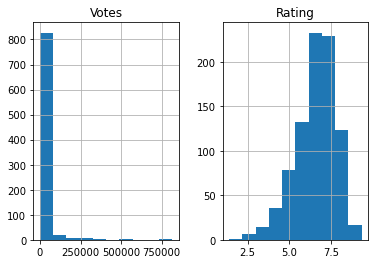

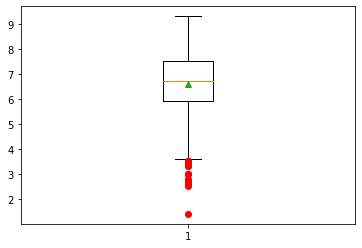

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 855----------------------


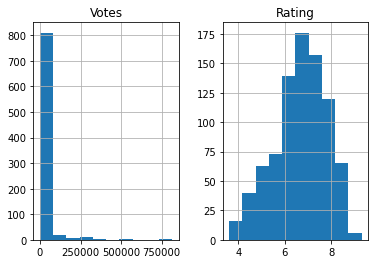

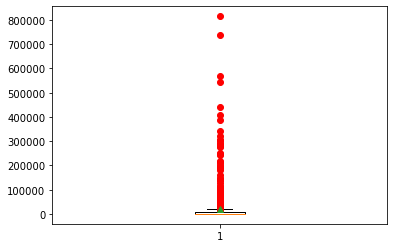

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 746----------------------


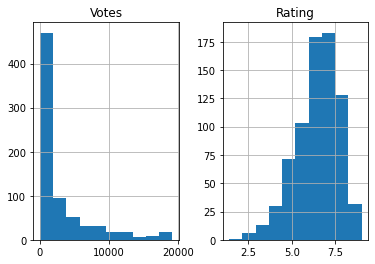

In [75]:
# understanding the Movie Ratings and Votes Data
#Shape of data
movie19_db.hist()

# Identifying and removing Outliers from Ratings
outlier(movie19_db, 'Rating')
outlier(movie19_db, 'Votes')
    
# movie ratings are now somewhat normally distributed   

In [76]:
new_genre = []
for i in movie19_db['Genre']:
    for j in i:
        new_genre.append(j.strip())
genre19_list = np.unique(new_genre)
genre19_list.sort()
genre19_list
genre19_df = pd.DataFrame({'Genre':genre19_list})
genre19_df
# row #17 list N/A as a Genre which needs to be removed
genre19_df = genre19_df.drop(index=17)
genre19_df

,Genre
0,Action
1,Adventure
2,Animation
3,Biography
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Family
9,Fantasy


In [78]:
final_rev_df = genre_revenue(rev_db,genre19_df)
# final_rev_df.drop(index = [1,6,8,9,10,11,12,15,16,18,19,20,21,22,23,24,25,26], inplace = True)#--------------------- how not to hard code
final_rev_df
# final_rev_df.plot('Genre','revenue',kind = 'bar')

,Genre,revenue
0,Action,730530696.0
1,Adventure,NaN
2,Animation,NaN
3,Biography,NaN
4,Comedy,NaN
5,Crime,NaN
6,Documentary,NaN
7,Drama,NaN
8,Family,NaN
9,Fantasy,NaN


In [38]:

rating_votes(movie19_db, genre19_df)


genre19_df

,Genre,revenue,Votes,Rating
0,Action,730530696.0,34.85274,510.100001
2,Animation,286511602.0,NaN,NaN
3,Biography,109366697.0,NaN,NaN
4,Comedy,256859426.0,NaN,NaN
5,Crime,319633372.0,NaN,NaN
7,Drama,115232301.0,NaN,NaN
13,Horror,173251682.0,NaN,NaN
14,Music,235066.0,NaN,NaN


In [65]:
#dropping empty genre Musical, Talk Show, War, Film Noir
genre19_df.drop(index=[10,15,23,25], inplace = True)

print(len(genre19_df))

22


<AxesSubplot:xlabel='Genre'>

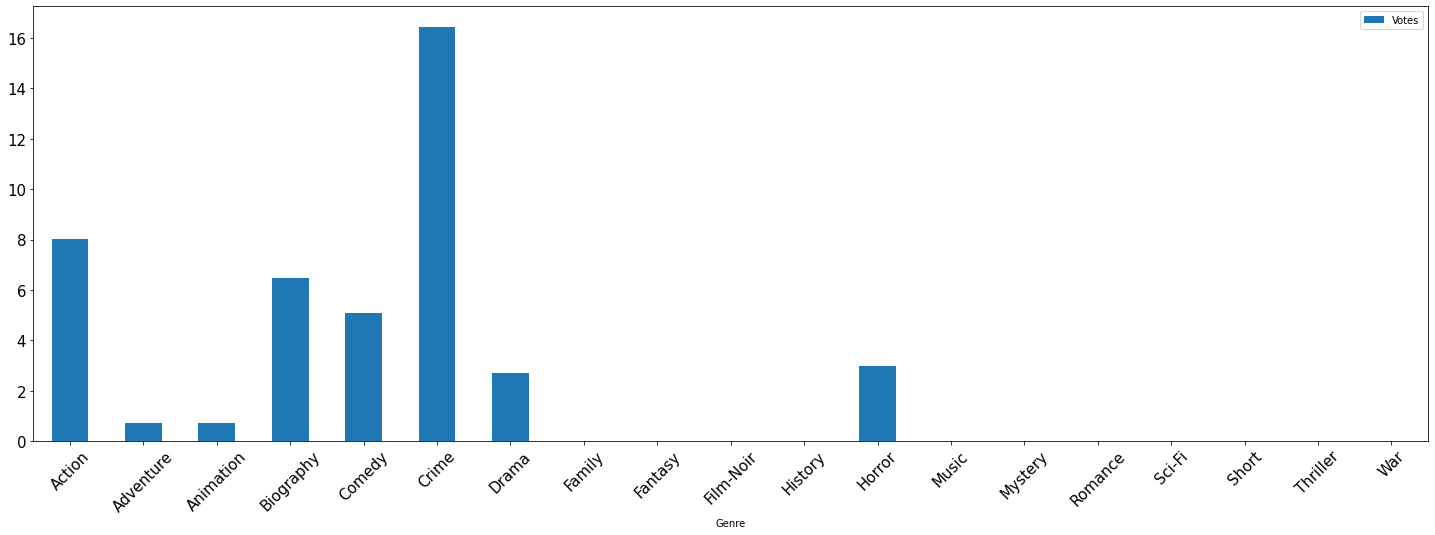

In [20]:
# Genre VS Votes Plot - 2019
genre19_df.plot('Genre', 'Votes', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

###  <jusitfy>The plot shows that for the year 2019, comedy was the most voted Genre. The number of votes may also be treated as an indirect indicator of the number of views of a given genre, as the data for exact number of views is not freely available.
### Keeping this in mind, one can safely say that 'Comedy' was the most viewed genre of 2019

<AxesSubplot:xlabel='Genre'>

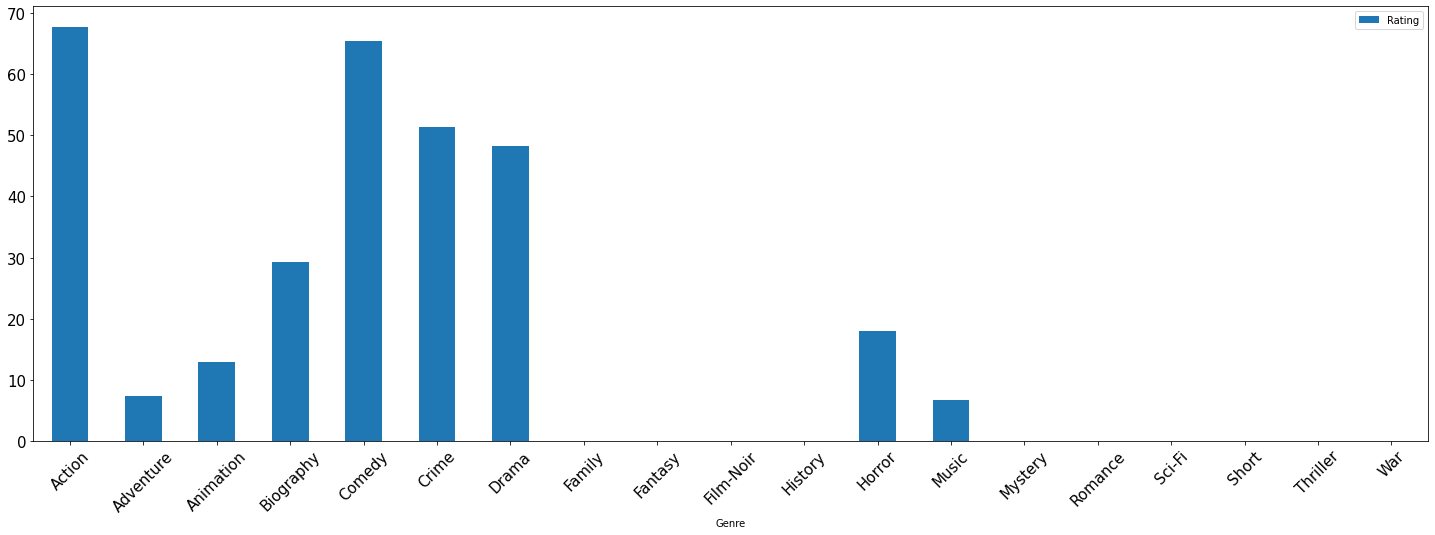

In [21]:
genre19_df.plot('Genre', 'Rating', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

### The plot shows that for the year 2019, comedy was the highest rated Genre. The ratings of the genre may also be treated as an indirect indicator of the number of views of a given genre, as the data for exact number of views is not freely available.
### Keeping this in mind, one can safely say that 'Comedy' was the most viewed genre of 2019

r is 0.7754841979756112 and p is 9.581479151376199e-05


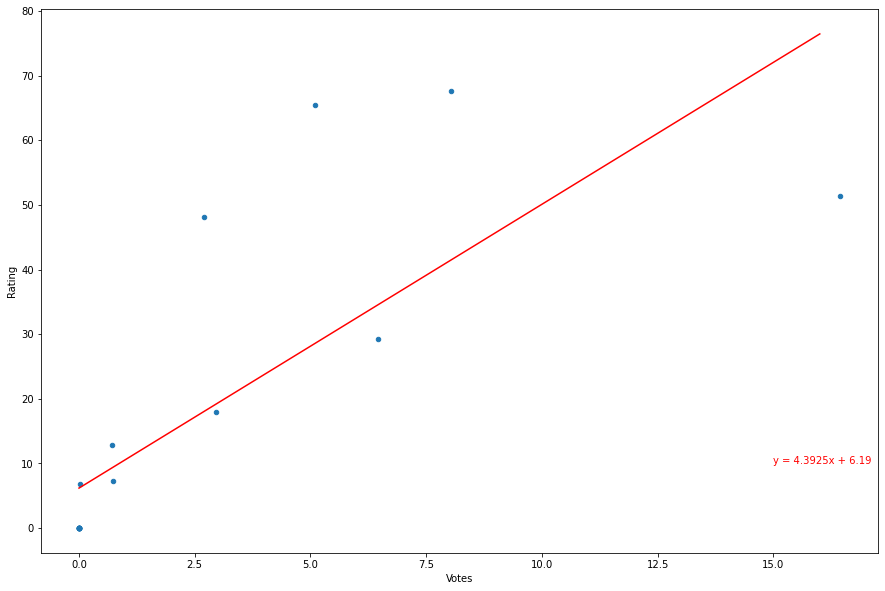

In [22]:
#---------------- to be discussed with Kevin-----------------------------------
genre19_df.plot('Votes','Rating', kind = 'scatter', figsize = (15,10), fontsize = 10)
x = genre19_df['Votes']
y = genre19_df['Rating']
nx = 15
ny = 10
regress(x,y, nx, ny)


# 2020 Movies Database


In [73]:

movie20_db = fetch_db(movie20)


--------------------------------------
Extracting Data from OMDB
--------------------------------------
Movie: The Shadow of Violence  details not found
Movie: Korean Pork Belly Rhapsody  details not found
Movie: Gameboys Level-Up Edition  details not found
Movie: SanPa: Sins of the Savior  details not found
Movie: Children of Adam  details not found
Movie: Futmalls.com  details not found
Movie: Manhunt: Deadly Games  details not found
Movie: Pokémon Journeys: The...  details not found
Movie: Don’t Listen  details not found
Movie: Andhakaaram  details not found
Movie: Flavorful Origins  details not found
Movie: Bakugan: Armored Alliance  details not found
Movie: Ya no estoy aquí: Una...  details not found
Movie: American Pie 9: Girls'...  details not found
Movie: StarBeam: Halloween Hero  details not found
Movie: The Book of Sun  details not found
Movie: Dolly Kitty Aur Woh...  details not found
Movie: Hope Frozen: A Quest to...  details not found
Movie: #Alive  details not found
Movie

In [74]:
movie20_db

,MovieID,Title,Votes,Rating,Genre
0,tt0038285,Accomplice,133,5.4,"[Film-Noir, Mystery, Thriller]"
1,tt7268736,Kilometers and Kilometers,703,6.3,"[Adventure, Comedy, Drama]"
2,tt9695258,So My Grandma's a Lesbian!,43,5.7,[Comedy]
3,tt8431078,Friendsgiving,758,4.2,"[Comedy, Drama]"
4,tt3547306,Cut Throat City,"1,201",4.8,"[Action, Crime, Drama, Thriller]"
...,...,...,...,...,...
820,tt9117054,Spinning Out,"9,879",7.7,"[Drama, Sport]"
821,tt4287320,The Circle,"84,386",5.3,"[Drama, Sci-Fi, Thriller]"
822,tt3986586,Fuller House,"24,723",6.8,"[Comedy, Family]"
823,tt11168104,Maradona in Mexico,890,7.2,"[Documentary, Comedy, Drama, Sport]"


In [75]:

# cleaning up the data
movie20_db['Votes'].replace(',','', regex=True, inplace=True)
movie20_db['Rating'].replace(',','', regex=True, inplace=True)
# remove commas from votes and ratings
movie20_db['Votes'] = movie19_db['Votes'].apply(pd.to_numeric, downcast='float', errors='coerce')
movie20_db['Rating'] = movie19_db['Rating'].apply(pd.to_numeric, downcast='float', errors='coerce')
# convert to float for numeric calculation

In [76]:
movie20_db.dtypes


MovieID     object
Title       object
Votes      float64
Rating     float64
Genre       object
dtype: object

In [40]:
#Dropping rows with null value
movie20_db.dropna(inplace=True)
len(movie20_db)

810

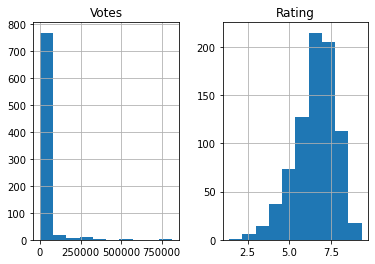

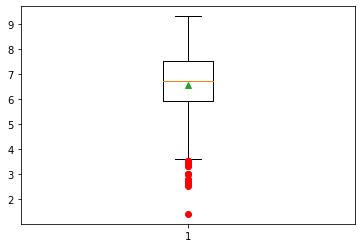

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 793----------------------


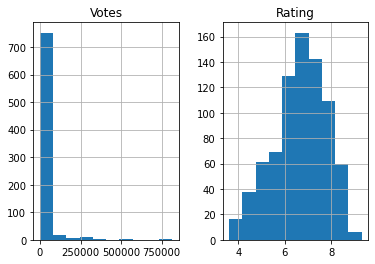

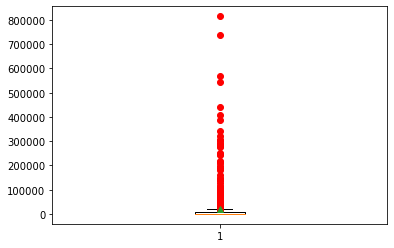

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 689----------------------


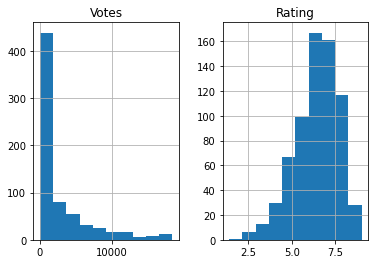

In [41]:
# understanding the Movie Ratings and Votes Data
#Shape of data
movie20_db.hist()

# Identifying and removing Outliers from Ratings
outlier(movie20_db, 'Rating')
outlier(movie20_db, 'Votes')
    
# movie ratings are now somewhat normally distributed  

In [43]:
new_genre = []
for i in movie20_db['Genre']:
    for j in i:
        new_genre.append(j.strip())
    
genre20_list = np.unique(new_genre)
genre20_list.sort()
genre20_list
genre20_df = pd.DataFrame({'Genre':genre20_list})
genre20_df #25 different genre
# row #17 list N/A as a Genre which needs to be removed
genre20_df = genre20_df.drop(index=17)
genre20_df

,Genre
0,Action
1,Adventure
2,Animation
3,Biography
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Family
9,Fantasy


In [45]:
rating_votes(movie20_db, genre20_df)
genre20_df

,Genre,Votes,Rating
0,Action,1358589.0,534.500003
1,Adventure,877348.0,86.799999
2,Animation,2127711.0,709.599998
3,Biography,371229.0,63.900001
4,Comedy,2440118.0,1279.000001
5,Crime,796275.0,279.700000
6,Documentary,1775186.0,760.500000
7,Drama,3742013.0,964.599997
8,Family,642909.0,88.700001
9,Fantasy,29795.0,21.300000


In [47]:
#dropping empty genre Musical, Mystery, News, Sci-Fi, Sport, War, Western
genre20_df.drop(index=[15,16,18,21,23,26,27], inplace = True)

print(len(genre20_df))

20


<AxesSubplot:xlabel='Genre'>

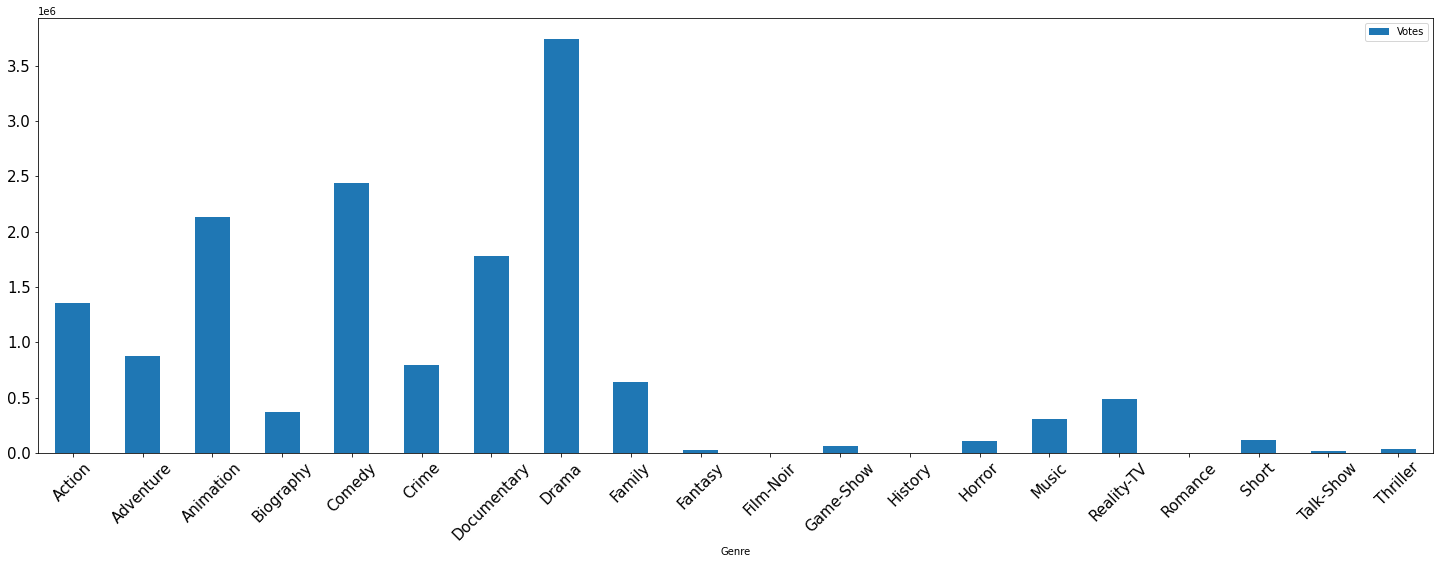

In [48]:
# Genre VS Votes Plot - 2020
genre20_df.plot('Genre', 'Votes', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

<AxesSubplot:xlabel='Genre'>

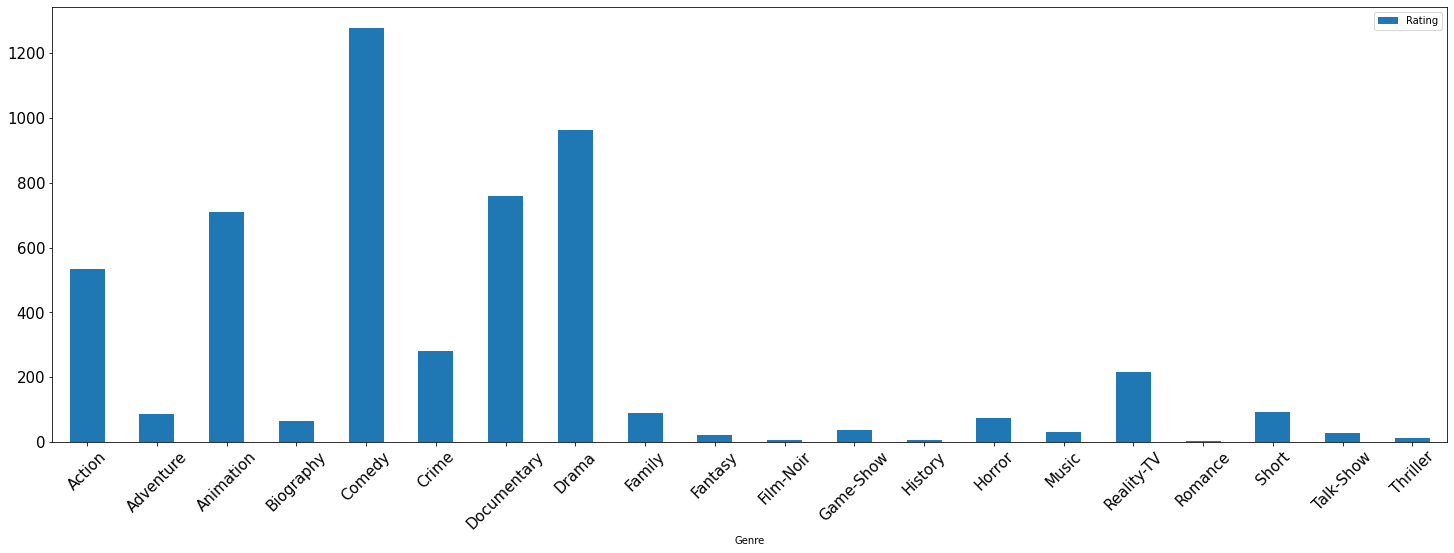

In [49]:
# Genre VS Rating Plot - 2020
genre20_df.plot('Genre', 'Rating', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

In [50]:
# fig, ax = plt.subplots()----------------------------to be discussed with Kevin
# size = 4
# x = genre_df['Genre']
# y1= genre_df['Votes']
# y2 = genre_df['Rating']

# cmap = plt.get_cmap("tab20c")
# outer_colors = cmap(np.arange(3)*4)
# inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

# ax.pie(y1, radius=1, colors=outer_colors,
#        wedgeprops=dict(width=size, edgecolor='w'), labels=x)

# ax.pie(y2, radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'), labels = x)

# plt.title='Votes VS Rating'
# plt.show()


r is 0.9217635706286316 and p is 7.831894919451455e-09


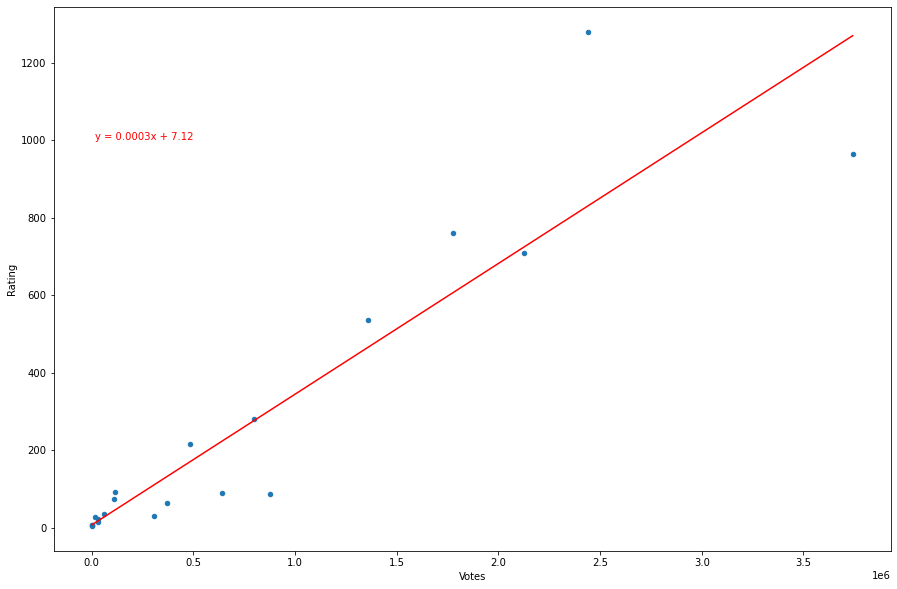

In [51]:
#---------------- to be discussed with Kevin-----------------------------------
genre20_df.plot('Votes','Rating', kind = 'scatter', figsize = (15,10), fontsize = 10)
x = genre20_df['Votes']
y = genre20_df['Rating']
nx = 15000
ny = 1000
regress(x,y, nx, ny)

In [71]:
# t test means of ratings and votes of 2019 & 2020 